# Pneumonia detection on chest X-ray

In [1]:
import numpy as np
import pandas as pd 
import random as rn

# tensorflow
import tensorflow.random as tfr
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Chart
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns
import glob

from skimage import color, exposure
from sklearn.metrics import classification_report

import os
import cv2

# Setting the same seed for repeatability

seed = 0

np.random.seed(seed) 
rn.seed(seed)
tfr.set_seed(seed)

# Display graphs in a Jupyter
%matplotlib inline

print("Imported")

Imported


In [2]:
data_path = '../input/chest-xray-pneumonia/chest_xray/chest_xray/'
data_path

train_path = data_path + 'train/'
test_path = data_path + 'test/'
val_path = data_path + 'val/'

In [3]:
img_size = 200

In [4]:
def read_data(data_paths):
    for data_path in data_paths:
        labels = ['PNEUMONIA', 'NORMAL']
        images = []
        y = []
        for label in labels:
            curr_path = data_path + label
            for img in os.listdir(curr_path):
                if ('DS' not in img):
                    image_path = os.path.join(curr_path, img)
                    image =  cv2.resize(cv2.imread(image_path), (img_size, img_size))
                    if image is not None:
                        images.append([image, label])
                
    images = np.asarray(images)
    return images

In [5]:
train = read_data([train_path])
test = read_data([val_path, test_path])

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [6]:
for i in range(10):
    np.random.shuffle(train)
    np.random.shuffle(test)

In [7]:
train_df = pd.DataFrame(train, columns=['image', 'label'])
test_df = pd.DataFrame(test, columns = ['image', 'label'])

In [8]:
train_df['label'].head()

0    PNEUMONIA
1    PNEUMONIA
2       NORMAL
3    PNEUMONIA
4    PNEUMONIA
Name: label, dtype: object

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


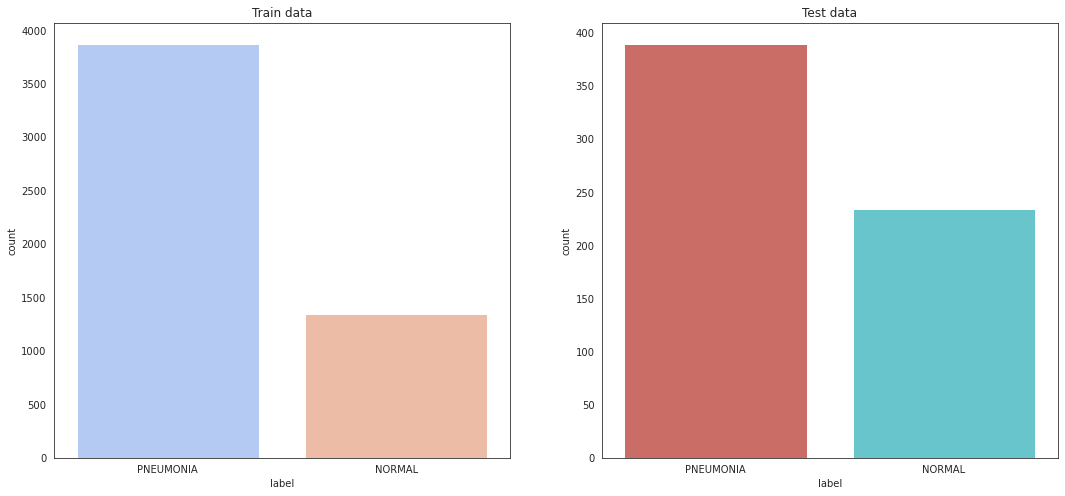

In [9]:
plt.figure(figsize=(18, 8))
sns.set_style("white")

plt.subplot(1,2,1)
sns.countplot(train_df['label'], palette = 'coolwarm')
plt.title('Train data')

plt.subplot(1,2,2)
sns.countplot(test_df['label'], palette = "hls")
plt.title('Test data')

plt.show()

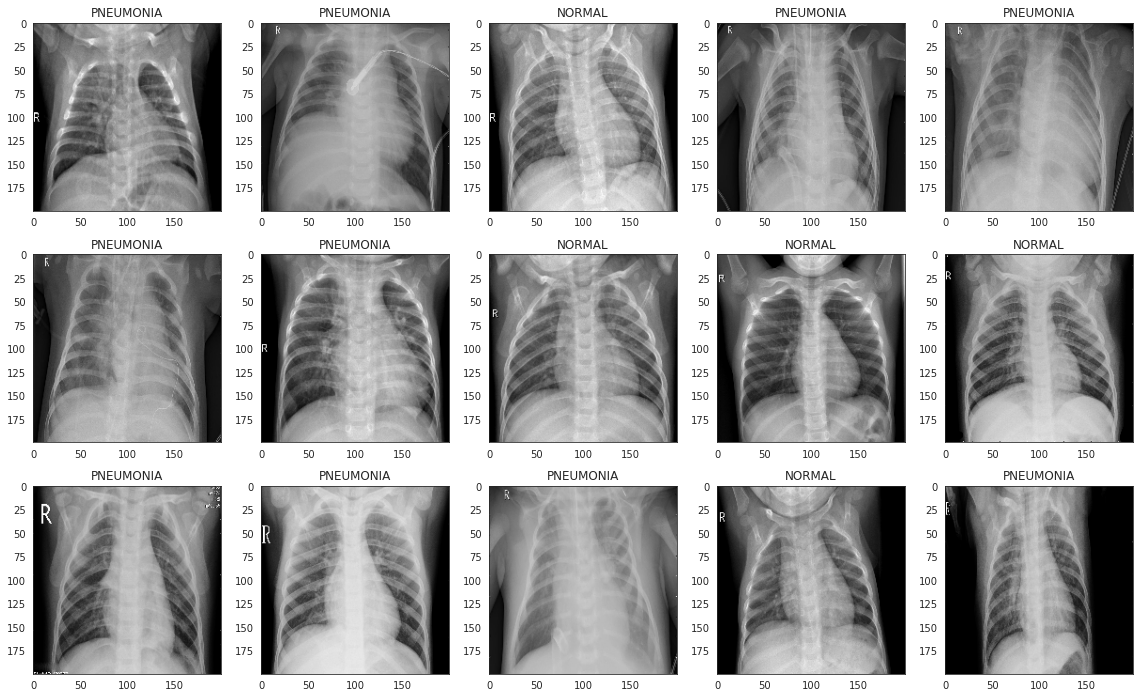

In [10]:
def Show_example_image():
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        plt.subplot(5, 5, idx+1)
        plt.imshow(train_df.iloc[idx]['image'])
        plt.title("{}".format(train_df.iloc[idx]['label']))
        
    plt.tight_layout()
    
Show_example_image()

In [11]:
def lung_condition(label):
    if label == 'NORMAL':
        return 0
    else:
        return 1

In [12]:
def splitdata(data):
    X = []
    y = []
    for i, (val, label) in enumerate(data):
        X.append(val)
        y.append(lung_condition(label))
    return np.array(X), np.array(y)

In [13]:
np.random.shuffle(train)
np.random.shuffle(test)
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

In [14]:
def preprocesing_to_mlp(data):
    data1 = color.rgb2gray(data).reshape(-1, img_size * img_size).astype('float32')
    
    # Data Normalization [0, 1]
    data1 /= 255
    
    return data1

In [15]:
X_train = preprocesing_to_mlp(X_train)
X_test = preprocesing_to_mlp(X_test)

In [16]:
num_pixels = X_train.shape[1] 

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_train.shape[1]

In [17]:
def draw_learning_curve(history, keys=['accuracy', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
    plt.show()

In [18]:
callbacks1 = [ 
    EarlyStopping(monitor = 'loss', patience = 6), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('../working/model.best1.hdf5',monitor='loss', save_best_only=True) # saving the best model
]

#### First model

In [19]:
def get_mlp():
    
    return Sequential([
        #input layer is automatic generation by keras
        
        #hidden layer
        Dense(1024, input_dim = num_pixels, activation='relu'),
        
        #output layer
        Dense(num_classes, activation='softmax')
    ])

In [20]:
model = get_mlp()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              40961024  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 40,963,074
Trainable params: 40,963,074
Non-trainable params: 0
_________________________________________________________________


In [21]:
learning_history = model.fit(X_train, y_train,
          batch_size = 64, epochs = 40, verbose = 2,
          callbacks = callbacks1,
          validation_data=(X_test, y_test));

Epoch 1/40
82/82 - 3s - loss: 0.3952 - accuracy: 0.8165 - val_loss: 0.4144 - val_accuracy: 0.7933
Epoch 2/40
82/82 - 1s - loss: 0.2046 - accuracy: 0.9241 - val_loss: 0.7736 - val_accuracy: 0.7019
Epoch 3/40
82/82 - 1s - loss: 0.1669 - accuracy: 0.9363 - val_loss: 0.5322 - val_accuracy: 0.7708
Epoch 4/40
82/82 - 1s - loss: 0.1335 - accuracy: 0.9507 - val_loss: 0.8916 - val_accuracy: 0.7131
Epoch 5/40
82/82 - 1s - loss: 0.1541 - accuracy: 0.9392 - val_loss: 0.4537 - val_accuracy: 0.8029
Epoch 6/40
82/82 - 1s - loss: 0.1248 - accuracy: 0.9538 - val_loss: 0.8661 - val_accuracy: 0.7244
Epoch 7/40
82/82 - 1s - loss: 0.1134 - accuracy: 0.9578 - val_loss: 0.7877 - val_accuracy: 0.7436
Epoch 8/40
82/82 - 1s - loss: 0.1172 - accuracy: 0.9565 - val_loss: 0.7044 - val_accuracy: 0.7692
Epoch 9/40
82/82 - 1s - loss: 0.1088 - accuracy: 0.9571 - val_loss: 1.0602 - val_accuracy: 0.7179
Epoch 10/40
82/82 - 1s - loss: 0.1155 - accuracy: 0.9565 - val_loss: 1.0296 - val_accuracy: 0.7196
Epoch 11/40
82/82 -

In [22]:
model = load_model('model.best1.hdf5')

In [23]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 99.42219257354736%
Test accuracy: 74.83974099159241%
MLP Error: 25.16%


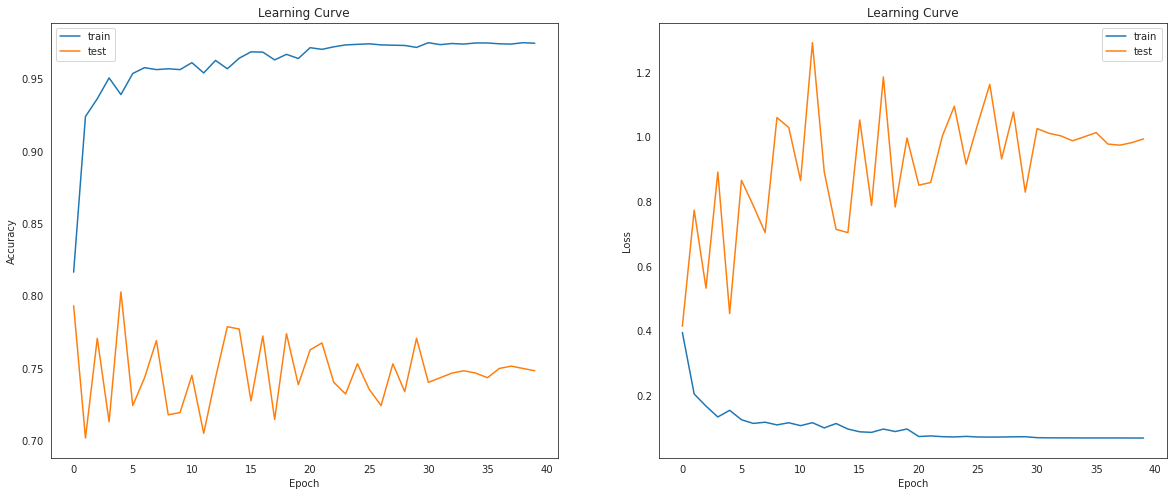

In [24]:
draw_learning_curve(learning_history)

#### Second Model

In [25]:
callbacks2 = [ 
    EarlyStopping(monitor = 'loss', patience = 6), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('../working/model.best2.hdf5', monitor='loss' , save_best_only=True) # saving the best model
]

In [26]:
def get_mlpv2():
    
    return Sequential([
        Dense(1024, input_dim=num_pixels, activation='relu'),
        Dropout(0.4),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

In [27]:
model = get_mlpv2()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1024)              40961024  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

In [28]:
learning_history = model.fit(X_train, y_train,
          batch_size = 64, epochs = 100, verbose = 1,
          callbacks = callbacks2,
          validation_data=(X_test, y_test));

Epoch 1/100
82/82 [==============================] - 2s 16ms/step - loss: 0.5353 - accuracy: 0.7474 - val_loss: 0.4160 - val_accuracy: 0.8141
Epoch 2/100
82/82 [==============================] - 1s 13ms/step - loss: 0.2616 - accuracy: 0.8929 - val_loss: 0.8354 - val_accuracy: 0.6891
Epoch 3/100
82/82 [==============================] - 1s 13ms/step - loss: 0.2449 - accuracy: 0.9002 - val_loss: 0.5697 - val_accuracy: 0.7580
Epoch 4/100
82/82 [==============================] - 1s 15ms/step - loss: 0.1800 - accuracy: 0.9312 - val_loss: 0.7970 - val_accuracy: 0.7372
Epoch 5/100
82/82 [==============================] - 1s 13ms/step - loss: 0.1402 - accuracy: 0.9489 - val_loss: 0.9777 - val_accuracy: 0.7019
Epoch 6/100
82/82 [==============================] - 1s 14ms/step - loss: 0.1532 - accuracy: 0.9410 - val_loss: 0.6453 - val_accuracy: 0.7596
Epoch 7/100
82/82 [==============================] - 1s 13ms/step - loss: 0.1376 - accuracy: 0.9478 - val_loss: 0.8199 - val_accuracy: 0.7436
Epoch 

In [29]:
model = load_model('model.best2.hdf5')

In [30]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 89.5776093006134%
Test accuracy: 76.12179517745972%
MLP Error: 23.88%


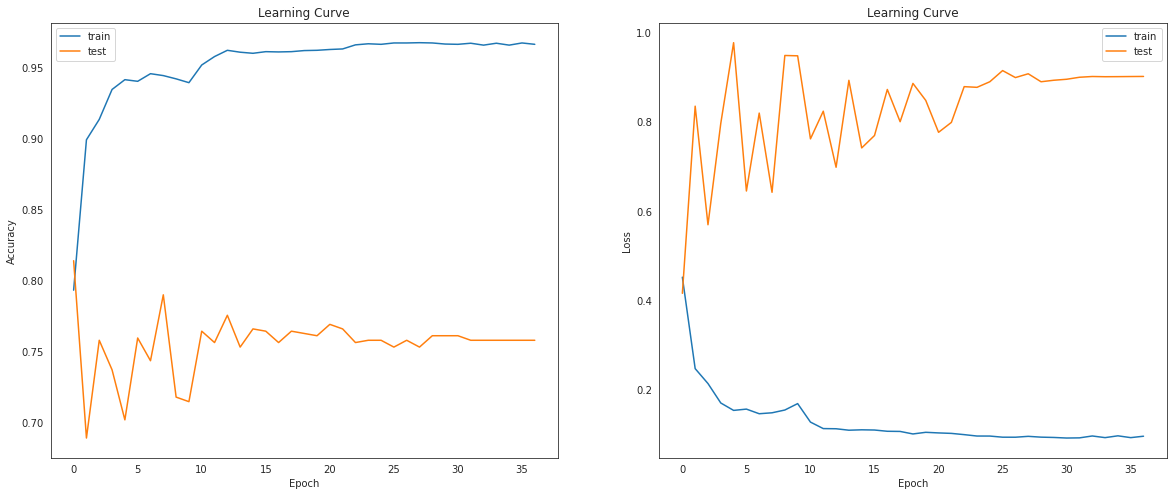

In [31]:
draw_learning_curve(learning_history)

In [32]:
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

In [33]:
def preprocesing_to_cnn(data):
    data1 = color.rgb2gray(data).reshape(-1, img_size, img_size, 1).astype('float32')
    data1 /= 255
    return data1

In [34]:
X_train = preprocesing_to_cnn(X_train)
X_test = preprocesing_to_cnn(X_test)

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [35]:
num_classes = y_train.shape[1]

In [36]:
input_shape = (img_size, img_size, 1)

In [37]:
callbacks3 = [ 
    EarlyStopping(monitor = 'loss', patience = 6), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('../working/model.best3.hdf5', monitor='loss' , save_best_only=True) # saving the best model
]

In [38]:
num_pixels 

40000

#### First model CNN

In [39]:
def get_modelcnn():
    return Sequential([
        
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        
        Flatten(),
        
        Dense(512, activation='relu'),
        Dropout(0.5),
        
        Dense(256, activation='relu'),
        Dropout(0.5),
        
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation = "softmax")
        
    ])

In [40]:
model = get_modelcnn()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 16)      2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 32)     

In [41]:
learning_history = model.fit(X_train, y_train,
          batch_size = 64,
          epochs = 100,
          verbose = 1,
          callbacks = callbacks3,
          validation_data = (X_test, y_test))

Epoch 1/100
82/82 [==============================] - 13s 94ms/step - loss: 2.1073 - accuracy: 0.6482 - val_loss: 5.1815 - val_accuracy: 0.6250
Epoch 2/100
82/82 [==============================] - 7s 81ms/step - loss: 0.4457 - accuracy: 0.8333 - val_loss: 6.2101 - val_accuracy: 0.6250
Epoch 3/100
82/82 [==============================] - 7s 83ms/step - loss: 0.2811 - accuracy: 0.9047 - val_loss: 7.3798 - val_accuracy: 0.6250
Epoch 4/100
82/82 [==============================] - 7s 82ms/step - loss: 0.2267 - accuracy: 0.9178 - val_loss: 4.6488 - val_accuracy: 0.6250
Epoch 5/100
82/82 [==============================] - 7s 83ms/step - loss: 0.1760 - accuracy: 0.9436 - val_loss: 5.5676 - val_accuracy: 0.6250
Epoch 6/100
82/82 [==============================] - 7s 81ms/step - loss: 0.1741 - accuracy: 0.9480 - val_loss: 2.8380 - val_accuracy: 0.6250
Epoch 7/100
82/82 [==============================] - 7s 81ms/step - loss: 0.1439 - accuracy: 0.9534 - val_loss: 2.5006 - val_accuracy: 0.6250
Epoch

In [42]:
model = load_model('model.best3.hdf5')

In [43]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 225.31390190124512%
Test accuracy: 77.40384340286255%
MLP Error: 22.60%


In [44]:
datagen = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False, 
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size = 32)

In [45]:
callbacks4 = [ 
    EarlyStopping(monitor = 'loss', patience = 7), 
    ReduceLROnPlateau(monitor = 'loss', patience = 4), 
    ModelCheckpoint('../working/model.best4.hdf5', monitor='loss' , save_best_only=True) # saving the best model
]

#### Second model CNN

In [46]:
def get_modelcnn_v2():
    return Sequential([
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Flatten(),
       
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(num_classes, activation = "softmax")
        
    ])

In [47]:
model = get_modelcnn_v2()
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 200, 200, 16)      160       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 200, 200, 16)      2320      
_________________________________________________________________
batch_normalization_5 (Batch (None, 200, 200, 16)      64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 100, 100, 32)      4640      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 100, 100, 32)     

In [48]:
learning_history = model.fit_generator((train_gen), 
                               epochs = 100, 
                               steps_per_epoch = X_train.shape[0] // 32,
                               validation_data = (X_test, y_test),
                               callbacks = callbacks4,
                        )

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
163/163 [==============================] - 22s 121ms/step - loss: 0.7243 - accuracy: 0.6742 - val_loss: 2.0324 - val_accuracy: 0.6250
Epoch 2/100
163/163 [==============================] - 21s 127ms/step - loss: 0.3379 - accuracy: 0.8748 - val_loss: 3.8047 - val_accuracy: 0.6250
Epoch 3/100
163/163 [==============================] - 19s 114ms/step - loss: 0.2476 - accuracy: 0.9140 - val_loss: 3.3765 - val_accuracy: 0.6250
Epoch 4/100
163/163 [==============================] - 21s 128ms/step - loss: 0.2033 - accuracy: 0.9295 - val_loss: 2.2964 - val_accuracy: 0.6250
Epoch 5/100
163/163 [==============================] - 20s 125ms/step - loss: 0.1683 - accuracy: 0.9355 - val_loss: 2.3824 - val_accuracy: 0.6250
Epoch 6/100
163/163 [==============================] - 20s 120ms/step - loss: 0.1577 - accuracy: 0.9422 - val_loss: 1.3509 - val_accuracy: 0.6250
Epoch 7/100
163/163 [==============================] - 21s 129ms/step - loss: 0.1423 - accuracy: 0.9478 - val_loss: 0.4379 -

In [49]:
model = load_model('model.best4.hdf5')

In [50]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 31.361567974090576%
Test accuracy: 91.82692170143127%
MLP Error: 8.17%


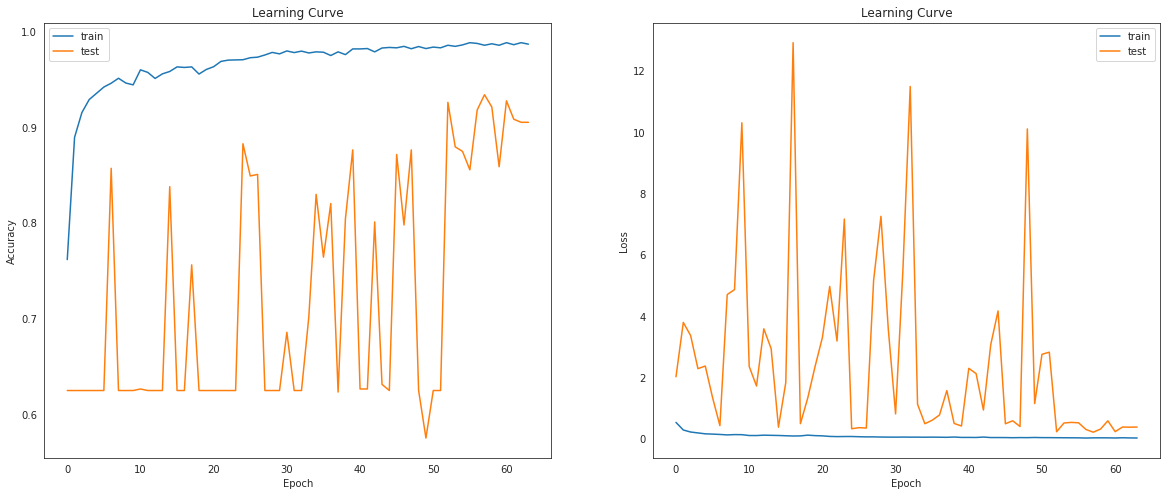

In [51]:
draw_learning_curve(learning_history)

In [52]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

In [53]:
y_pre_test = np.argmax(y_test, axis = 1)

In [54]:
def show_condition(num):
    if num == 0:
        return 'NORMAL'
    return 'PNEUMONIA'

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


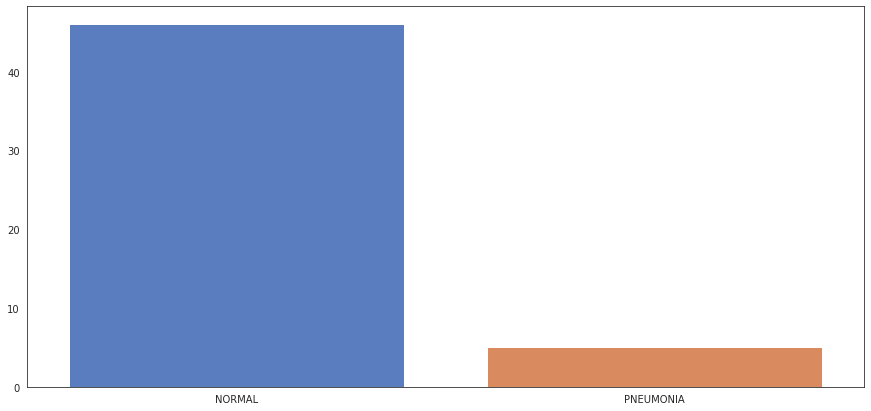

In [55]:
cnt_error = []
for idx, (a, b) in enumerate(zip(y_pre_test, y_pred)):
    if a == b: continue
    cnt_error.append(a)# test

cnt_error = np.unique(cnt_error, return_counts = True)
#sns.set_style("darkgrid")
sns.set_style("white")
plt.figure(figsize = (15, 7))
sns.barplot([show_condition(x) for x in cnt_error[0]], cnt_error[1], palette="muted")
plt.show()

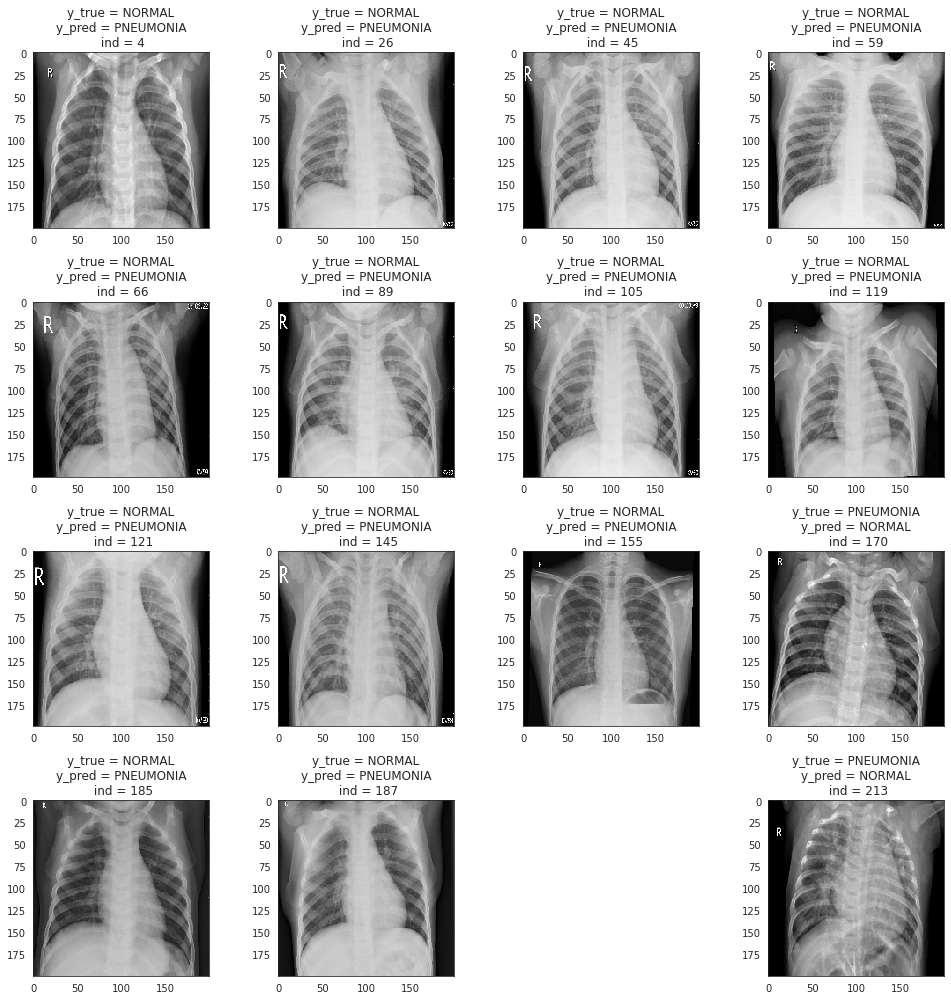

In [56]:
cnt_ind = 1
list_idx = []
fig = plt.figure(figsize=(14, 14))
X_test_plot = X_test.reshape(-1, img_size, img_size)
for idx, (a, b) in enumerate(zip(y_pre_test, y_pred)):
    if(cnt_ind > 16):break
    if a == b: continue
    plt.subplot(4, 4, cnt_ind)
    plt.imshow(X_test_plot[idx], cmap='gray', interpolation='none')
    plt.title('y_true = {0}\ny_pred = {1}\n ind = {2}'.format(show_condition(a), show_condition(b), idx))
    plt.tight_layout()
    list_idx.append(idx)
    cnt_ind += 1

In [57]:
print(classification_report(y_pre_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.80      0.88       234
           1       0.89      0.99      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624

